In [ ]:
!nvidia-smi ## watch -n0.1 nvidia-smi to monitor real time GPUs

Mon Mar 20 14:09:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.8 MB/s eta 0:00:00


#Image classification with PyTorch



### Learn from tutorial (No pre-trained)
- To understanding training loop
- Use CIFAR10 dataset
- Build-in function custom dataset

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Torch metric : https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html

#### import library

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

### build simple cnn
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy, Recall

In [ ]:
print(torch.version.cuda)

11.6


#### load dataset

In [ ]:
batch_size=16

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
trainloader

In [ ]:
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

In [ ]:
testloader

In [ ]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### show image

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

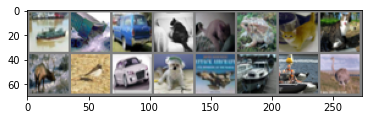

ship  truck car   cat   cat   frog  cat   cat   deer  bird  car   dog   plane ship  ship  bird 


In [ ]:
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [ ]:
images.size()

torch.Size([16, 3, 32, 32])

#### Build Simple CNNs

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) ## เปลี่ยน num_classes ตัวที่สอง

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to("cuda")
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#### Define optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

#### Training loop

In [ ]:
def train_one_epoch(epoch_index, acc_metrics):
    running_loss = 0.
    last_loss = 0.
    
    pbar = tqdm(trainloader, desc='Training')
    for i, data in enumerate(pbar):
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        
        optimizer.zero_grad()
        outputs = net(inputs) ## model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        avg_loss = running_loss / (i + 1)

        acc_metrics.update(outputs, labels)
        
        pbar.set_postfix({
            'train_loss': avg_loss,
            'train_acc': '{:.6f}'.format(float(acc_metrics.compute())) #* 100
        })
    
    last_loss = running_loss / len(trainloader)
            
    return last_loss

In [ ]:
# save_dir = 'models'
# os.makedirs(save_dir, exist_ok=True)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epoch_number = 0

EPOCHS = 15
best_vloss = 1_000_000.
best_vacc = 0
best_vscore = 0

device = "cuda"

train_acc = Accuracy(task="multiclass", num_classes=10).to(device)
val_acc = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    net.train(True)
    avg_loss = train_one_epoch(epoch_number, train_acc)

    net.train(False)
    acc = float(train_acc.compute()) #* 100
    
    running_vloss = 0.0
    with torch.no_grad():
        for i, vdata in enumerate(tqdm(testloader, desc='Validation')):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            
            voutputs = net(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            
            val_acc.update(voutputs, vlabels)
            
    avg_vloss = running_vloss / (i + 1)
    vacc = float(val_acc.compute())
    print('LOSS: train {} valid {}'.format(avg_loss, avg_vloss))
    print('ACCURACY: train {} valid {}'.format(acc, vacc))

    train_loss_list.append(avg_loss)
    train_acc_list.append(acc)
    val_loss_list.append(avg_vloss)
    val_acc_list.append(vacc)

    ## save best model
    # if vscore > best_vscore:
    #     best_vscore = vscore
    #     model_path = os.path.join(save_dir, 'best_model_{}.pt'.format(model_name))
    #     torch.save(model.state_dict(), model_path)
    #     print('New best model saved.')
        
    train_acc.reset()
    val_acc.reset()
    
    lr_scheduler.step(avg_vloss)
    epoch_number += 1

EPOCH 1:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 1.5215216213989258 valid 1.271268606185913
ACCURACY: train 0.44633999466896057 valid 0.5450000166893005
EPOCH 2:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 1.2299475198364258 valid 1.188094973564148
ACCURACY: train 0.5621799826622009 valid 0.5777999758720398
EPOCH 3:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 1.114429484539032 valid 1.1339002847671509
ACCURACY: train 0.6069599986076355 valid 0.5925999879837036
EPOCH 4:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 1.037894804906845 valid 1.1099677085876465
ACCURACY: train 0.6322199702262878 valid 0.6079999804496765
EPOCH 5:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.9760132922029495 valid 1.092282772064209
ACCURACY: train 0.6543999910354614 valid 0.6122999787330627
EPOCH 6:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.9284823881864548 valid 1.0751051902770996
ACCURACY: train 0.672819972038269 valid 0.6310999989509583
EPOCH 7:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.888409451379776 valid 1.0822806358337402
ACCURACY: train 0.6863600015640259 valid 0.6355000138282776
EPOCH 8:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.8480462871217728 valid 1.0713884830474854
ACCURACY: train 0.7001199722290039 valid 0.6359000205993652
EPOCH 9:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.8159496538543701 valid 1.0604816675186157
ACCURACY: train 0.7099199891090393 valid 0.6366999745368958
EPOCH 10:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.7818815299987792 valid 1.0968974828720093
ACCURACY: train 0.7218400239944458 valid 0.6370999813079834
EPOCH 11:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.7541482560110092 valid 1.1310309171676636
ACCURACY: train 0.7308800220489502 valid 0.635200023651123
EPOCH 12:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.7273171206927299 valid 1.1235077381134033
ACCURACY: train 0.7420200109481812 valid 0.6363999843597412
EPOCH 13:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.7038927076756955 valid 1.1417855024337769
ACCURACY: train 0.749019980430603 valid 0.6348999738693237
EPOCH 14:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.6820234650421143 valid 1.16267991065979
ACCURACY: train 0.7537800073623657 valid 0.6365000009536743
EPOCH 15:


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

LOSS: train 0.663239760813713 valid 1.2073298692703247
ACCURACY: train 0.7625399827957153 valid 0.6281999945640564
Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


In [ ]:
def plot_curve(train_loss_list,train_acc_list,val_loss_list,val_acc_list):
  epochs = range(1, len(train_loss_list) + 1)  
  # Define a subplot 
  fig, axs = plt.subplots(1,2,figsize=(15,4))
    
  # Plot loss
  loss_plot = axs[0]
    
  loss_plot.plot(epochs, train_loss_list, 'c--', label='Training loss')
  loss_plot.plot(epochs, val_loss_list, 'b', label='Validation loss')
  loss_plot.set_title('Training and validation loss')
  loss_plot.set_xlabel('Epochs')
  loss_plot.set_ylabel('Loss')
  loss_plot.legend()
    
  # Plot accuracy
  acc_plot = axs[1]
    
  acc_plot.plot(epochs, train_acc_list, 'c--', label='Training acc')
  acc_plot.plot(epochs, val_acc_list, 'b', label='Validation acc')
  acc_plot.set_title('Training and validation accuracy')
  acc_plot.set_xlabel('Epochs')
  acc_plot.set_ylabel('Accuracy')
  acc_plot.legend()

In [ ]:
new_val_loss_list = []
for item in val_loss_list:
  new_val_loss_list.append(item.to("cpu"))

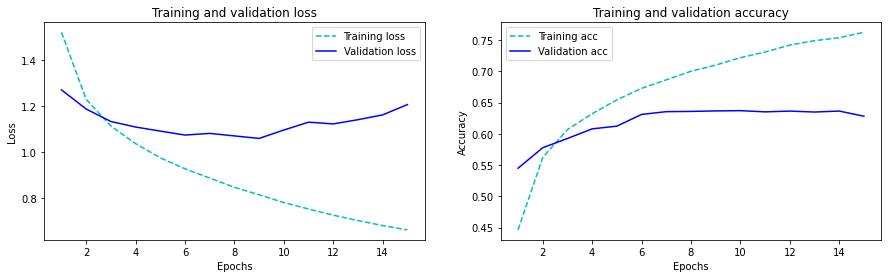

In [ ]:
plot_curve(train_loss_list,train_acc_list,new_val_loss_list,val_acc_list)

#### Testing model

In [ ]:
test_acc = Accuracy(task="multiclass", num_classes=10).to(device)
test_recall = Recall(task="multiclass", num_classes=10, average='weighted').to(device)

with torch.no_grad():
    for i, vdata in enumerate(tqdm(testloader, desc='Test')):
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        
        voutputs = net(vinputs)
        
        test_acc.update(voutputs, vlabels)
        test_recall.update(voutputs, vlabels)
        
tacc = float(test_acc.compute())
trecall = test_recall.compute().tolist()

print('ACCURACY: valid {}'.format(tacc))
print('RECALL: valid {}'.format(trecall))

Test:   0%|          | 0/625 [00:00<?, ?it/s]

ACCURACY: valid 0.6281999945640564
RECALL: valid 0.6281999945640564


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 62.82%


- Accuracy each class

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.5 %
Accuracy for class: car   is 74.5 %
Accuracy for class: bird  is 51.8 %
Accuracy for class: cat   is 36.5 %
Accuracy for class: deer  is 52.8 %
Accuracy for class: dog   is 50.6 %
Accuracy for class: frog  is 77.8 %
Accuracy for class: horse is 71.2 %
Accuracy for class: ship  is 78.6 %
Accuracy for class: truck is 70.9 %


### Cat and dog classification using pre-trained (timm)
- Write custom dataset
- Use timm

#### import library

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy, Recall
import timm

#### Setup environment

In [ ]:
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [ ]:
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

 62% 40.0M/64.4M [00:00<00:00, 143MB/s]
100% 64.4M/64.4M [00:00<00:00, 191MB/s]


In [ ]:
!unzip cats-and-dogs-image-classification.zip

Archive:  cats-and-dogs-image-classification.zip
  inflating: test/cats/cat_1.jpg     
  inflating: test/cats/cat_106.jpg   
  inflating: test/cats/cat_109.jpg   
  inflating: test/cats/cat_113.jpg   
  inflating: test/cats/cat_114.jpg   
  inflating: test/cats/cat_116.jpg   
  inflating: test/cats/cat_118.jpg   
  inflating: test/cats/cat_119.jpg   
  inflating: test/cats/cat_124.jpg   
  inflating: test/cats/cat_140.jpg   
  inflating: test/cats/cat_147.jpg   
  inflating: test/cats/cat_156.jpg   
  inflating: test/cats/cat_158.jpg   
  inflating: test/cats/cat_162.jpg   
  inflating: test/cats/cat_18.jpg    
  inflating: test/cats/cat_190.jpg   
  inflating: test/cats/cat_203.jpg   
  inflating: test/cats/cat_223.jpg   
  inflating: test/cats/cat_234.jpg   
  inflating: test/cats/cat_244.jpg   
  inflating: test/cats/cat_251.jpg   
  inflating: test/cats/cat_255.jpg   
  inflating: test/cats/cat_268.jpg   
  inflating: test/cats/cat_279.jpg   
  inflating: test/cats/cat_281.jpg   
 

#### Data preparation

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224,224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_dataset =torchvision.datasets.ImageFolder('/content/train', transform)
test_dataset = torchvision.datasets.ImageFolder('/content/test', transform)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
classes = ('cat', 'dog')

In [ ]:
print("Train :",len(train_dataset))
print("Eval :",len(test_dataset))
print("Test :",len(test_dataset))

Train : 557
Eval : 140
Test : 140


#### Model building

In [ ]:
timm.list_models('*', pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [ ]:
model_name = "resnet50"

In [ ]:
model = timm.create_model(model_name, in_chans=3, num_classes=2, pretrained=True)
### ตรงนี้ถ้าเอาไปใช้ใน lanta (gpu) มันจะต่อเน็ตไม่ได้นะคะ ให้ทำการ 
### 1. cd /root/.cache/torch/hub/checkpoints/ ที่หน้า frontend
### 2. wget (ลิ้งค์ที่มันฟ้องดาวน์โหลด)
### 3. รัน cell นี้ใหม่ มันจะได้

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
model.fc

Linear(in_features=2048, out_features=2, bias=True)

In [ ]:
device = "cuda"

In [ ]:
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

#### Define optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

#### Training loop

In [ ]:
def train_one_epoch(epoch_index, acc_metrics):
    running_loss = 0.
    last_loss = 0.
    
    pbar = tqdm(train_loader, desc='Training')
    for i, data in enumerate(pbar):
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        
        optimizer.zero_grad()
        outputs = model(inputs) ## model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        avg_loss = running_loss / (i + 1)

        acc_metrics.update(outputs, labels)
        
        pbar.set_postfix({
            'train_loss': avg_loss,
            'train_acc': '{:.6f}'.format(float(acc_metrics.compute())) #* 100
        })
    
    last_loss = running_loss / len(train_loader)
            
    return last_loss

In [ ]:
# save_dir = 'models'
# os.makedirs(save_dir, exist_ok=True)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epoch_number = 0

EPOCHS = 15
best_vloss = 1_000_000.
best_vacc = 0
best_vscore = 0

device = "cuda"

train_acc = Accuracy(task="multiclass", num_classes=2).to(device)
val_acc = Accuracy(task="multiclass", num_classes=2).to(device)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, train_acc)

    model.train(False)
    acc = float(train_acc.compute())
    
    running_vloss = 0.0
    with torch.no_grad():
        for i, vdata in enumerate(tqdm(val_loader, desc='Validation')):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            
            val_acc.update(voutputs, vlabels)
            
    avg_vloss = running_vloss / (i + 1)
    vacc = float(val_acc.compute())
    print('LOSS: train {} valid {}'.format(avg_loss, avg_vloss))
    print('ACCURACY: train {} valid {}'.format(acc, vacc))

    train_loss_list.append(avg_loss)
    train_acc_list.append(acc)
    val_loss_list.append(avg_vloss)
    val_acc_list.append(vacc)

    ## save best model
    # if vacc > best_vscore:
    #     best_vscore = vacc
    #     model_path = os.path.join(save_dir, 'best_model_{}.pt'.format(model_name))
    #     torch.save(model.state_dict(), model_path)
    #     print('New best model saved.')
        
    train_acc.reset()
    val_acc.reset()
    
    lr_scheduler.step(avg_vloss)
    epoch_number += 1

EPOCH 1:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.04241514535776029 valid 0.2431156188249588
ACCURACY: train 0.9874326586723328 valid 0.9571428298950195
EPOCH 2:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.01531171800969686 valid 0.24992786347866058
ACCURACY: train 0.9928186535835266 valid 0.9285714030265808
EPOCH 3:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.0468172759445022 valid 0.09457679837942123
ACCURACY: train 0.985637366771698 valid 0.949999988079071
EPOCH 4:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.028746743958132964 valid 0.16965769231319427
ACCURACY: train 0.9964093565940857 valid 0.9142857193946838
EPOCH 5:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.04261095453208933 valid 0.26288825273513794
ACCURACY: train 0.9964093565940857 valid 0.9142857193946838
EPOCH 6:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.043665990226953805 valid 0.08947494626045227
ACCURACY: train 0.9838420152664185 valid 0.9642857313156128
EPOCH 7:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.047921655014053814 valid 0.09112754464149475
ACCURACY: train 0.9928186535835266 valid 0.9714285731315613
EPOCH 8:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.020897306993396744 valid 0.057455528527498245
ACCURACY: train 0.9928186535835266 valid 0.9857142567634583
EPOCH 9:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.004497359235150118 valid 0.04143187031149864
ACCURACY: train 1.0 valid 0.9857142567634583
EPOCH 10:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.004372603568804657 valid 0.041955478489398956
ACCURACY: train 1.0 valid 0.9785714149475098
EPOCH 11:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.001271504396855663 valid 0.05949708819389343
ACCURACY: train 1.0 valid 0.9714285731315613
EPOCH 12:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.0006394734361189572 valid 0.04438282176852226
ACCURACY: train 1.0 valid 0.9714285731315613
EPOCH 13:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.0005258126010529748 valid 0.045158978551626205
ACCURACY: train 1.0 valid 0.9785714149475098
EPOCH 14:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.001850473964117959 valid 0.08107193559408188
ACCURACY: train 0.9982046484947205 valid 0.9714285731315613
EPOCH 15:


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

LOSS: train 0.0006785347852403194 valid 0.0696885883808136
ACCURACY: train 1.0 valid 0.9714285731315613
Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


#### Testing model

In [ ]:
test_acc = Accuracy(task="multiclass", num_classes=2).to(device)
test_recall = Recall(task="multiclass", num_classes=2, average=None).to(device)

with torch.no_grad():
    for i, vdata in enumerate(tqdm(val_loader, desc='Test')): ## เปลี่ยนเป็น test นะจ้ะอันนี้ไม่ได้แบ่งไว้เลยใช้ val ไปก่อน
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        
        voutputs = model(vinputs)
        
        test_acc.update(voutputs, vlabels)
        test_recall.update(voutputs, vlabels)
        
tacc = float(test_acc.compute())
trecall = test_recall.compute().tolist()

print('ACCURACY: valid {}'.format(tacc))
print('RECALL: valid {}'.format(trecall))

Test:   0%|          | 0/5 [00:00<?, ?it/s]

ACCURACY: valid 0.9714285731315613
RECALL: valid [0.9428571462631226, 1.0]


- Accuracy each class (เอามาจาก tutorial ของ PyTorch)

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader: ## เปลี่ยนเป็น test นะจ้ะอันนี้ไม่ได้แบ่งไว้เลยใช้ val ไปก่อน
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 94.3 %
Accuracy for class: dog   is 100.0 %


### **How to create a confusion matrix using PyTorch** : 

https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7